# Lecture 5 and 6: Class demo

## Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

c = os.path.join(os.path.abspath(".."), (".."), "data/")
DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")
pd.set_option("display.max_colwidth", 200)

<br><br>

## Data and splitting

Do you recall [the restaurants survey](https://ubc.ca1.qualtrics.com/jfe/form/SV_73VuZiuwM1eDVrw) you completed at the start of the course?

Let's use that data for this demo. You'll find a [wrangled version](../../data/cleaned_restaurant_data.csv) in the course repository.

In [2]:
df = pd.read_csv(DATA_DIR + 'cleaned_restaurant_data.csv')

In [3]:
df

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name,target
0,Yes,3.0,29,10.0,120.0,Italian,medium,Yes,Ambience,NaN,dislike
1,Yes,2.0,23,3.0,20.0,Canadian/American,no music,No,food tastes bad,NaN,dislike
2,Yes,2.0,21,20.0,15.0,Chinese,medium,Yes,bad food,NaN,dislike
3,No,2.0,24,14.0,18.0,Other,medium,No,Overall vibe on the restaurant,NaN,dislike
4,Yes,5.0,23,30.0,20.0,Chinese,medium,Yes,A bad day,NaN,dislike
...,...,...,...,...,...,...,...,...,...,...,...
959,No,10.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,like
960,Yes,1.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,like
961,No,1.0,22,40.0,50.0,Chinese,medium,Yes,The self service sauce table is very clean and the sauces were always filled up.,Haidilao,like
962,Yes,3.0,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,like


In [4]:
df.describe()

,eat_out_freq,age,n_people,price
count,964.000000,964.000000,6.960000e+02,696.000000
mean,2.585187,23.975104,1.439254e+04,1472.179152
std,2.246486,4.556716,3.790481e+05,37903.575636
min,0.000000,10.000000,-2.000000e+00,0.000000
25%,1.000000,21.000000,1.000000e+01,18.000000
50%,2.000000,22.000000,2.000000e+01,25.000000
75%,3.000000,26.000000,3.000000e+01,40.000000
max,15.000000,46.000000,1.000000e+07,1000000.000000


Are there any unusual values in this data that you notice?
Let's get rid of these outliers. 

In [5]:
df["price"].quantile(0.99)

np.float64(200.0)

In [6]:
upperbound_price = 200
lowerbound_people = 1
df = df[~(df['price'] > 200)]
restaurant_df = df[~(df['n_people'] < lowerbound_people)]
restaurant_df.shape

(942, 11)

In [7]:
restaurant_df.describe()

,eat_out_freq,age,n_people,price
count,942.000000,942.000000,674.000000,674.000000
mean,2.598057,23.992569,24.973294,34.023279
std,2.257787,4.582570,22.016660,29.018622
min,0.000000,10.000000,1.000000,0.000000
25%,1.000000,21.000000,10.000000,18.000000
50%,2.000000,22.000000,20.000000,25.000000
75%,3.000000,26.000000,30.000000,40.000000
max,15.000000,46.000000,200.000000,200.000000


We aim to predict whether a restaurant is liked or disliked.

In [8]:
# Separate `X` and `y`. 
X = restaurant_df.drop(columns=['target'])
y = restaurant_df['target']

Below I'm perturbing this data just to demonstrate a few concepts. Don't do it in real life. 

In [9]:
X.at[459, 'food_type'] = 'Quebecois'
X['price'] = X['price'] * 100

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<br><br>

## Exploratory data analysis 

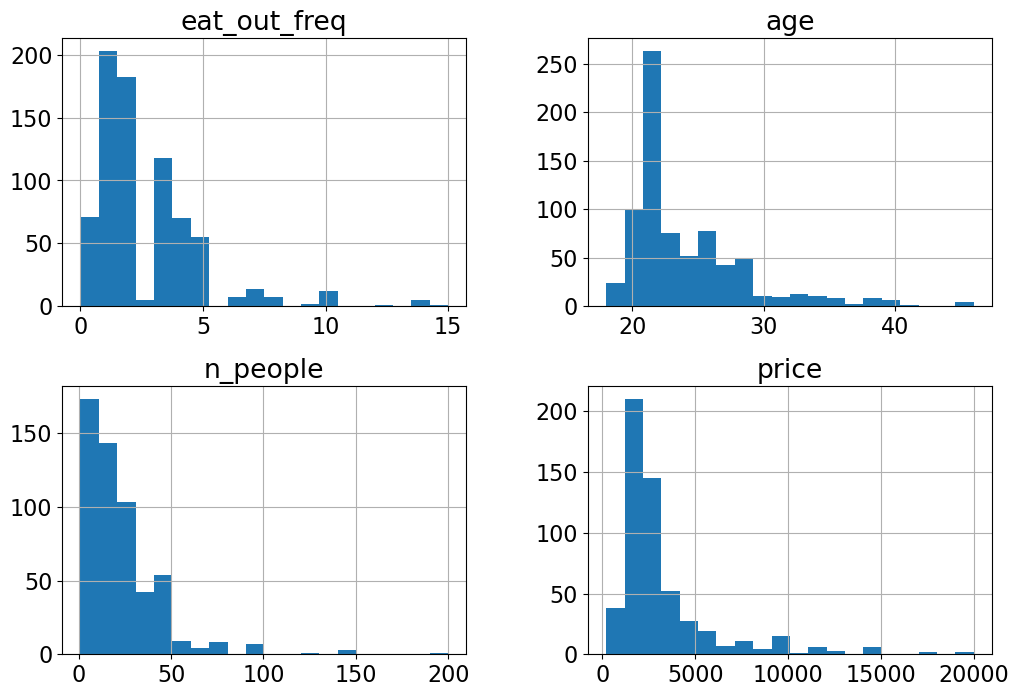

In [11]:
X_train.hist(bins=20, figsize=(12, 8));

Do you see anything interesting in these plots? 

In [12]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Thai                  20
Fusion                18
Mexican               17
fusion                 3
Quebecois              1
Name: count, dtype: int64

Error in data collection? Probably "Fusion" and "fusion" categories should be combined?

In [13]:
# Replace "fusion" with "Fusion"
X_train["food_type"] = X_train["food_type"].replace({"fusion": "Fusion"})
X_test["food_type"] = X_test["food_type"].replace({"fusion": "Fusion"})

In [14]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

Again, usually we should spend lots of time in EDA, but let's stop here so that we have time to learn about transformers and pipelines.   

<br><br>

## Modeling 

### Dummy Classifier

In [15]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000789,0.000415,0.516556,0.514950
1,0.000507,0.000332,0.516556,0.514950
2,0.000558,0.000312,0.516556,0.514950
3,0.000432,0.000556,0.513333,0.515755
4,0.000450,0.000339,0.513333,0.515755


We have a relatively balanced distribution of both 'like' and 'dislike' classes.

<br><br>

### Let's try KNN on this data

Do you think KNN would work directly on `X_train` and `y_train`?

In [16]:
# Preprocessing and pipeline
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

ValueError: could not convert string to float: 'No'

<br><br><br><br><br><br>
- We need to preprocess the data before feeding it into machine learning models. What are the different types of features in the data?
- What transformations are necessary before training a machine learning model?
- Can we categorize features based on the type of transformations they require?

In [17]:
X_train[4:11]

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name
62,Yes,2.0,24,20.0,3000.0,Indian,high,Yes,bad taste,east is east
694,No,0.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,No,5.0,21,50.0,3500.0,Canadian/American,high,Yes,5,Joeys Shipyards
677,Yes,3.0,20,30.0,2000.0,Mexican,low,Yes,NaN,NaN
161,No,0.0,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,Yes,3.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Yes,2.0,21,30.0,3000.0,Chinese,medium,Yes,food that didn't come,Happy Lamb


In [18]:
X_train.columns

Index(['north_america', 'eat_out_freq', 'age', 'n_people', 'price',
       'food_type', 'noise_level', 'good_server', 'comments',
       'restaurant_name'],
      dtype='object')

In [19]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

In [20]:
X_train['north_america'].value_counts()

north_america
Yes                    415
No                     330
Don't want to share      8
Name: count, dtype: int64

In [21]:
X_train['good_server'].value_counts()

good_server
Yes    396
No     148
Name: count, dtype: int64

In [22]:
X_train['noise_level'].value_counts()

noise_level
medium        232
low           186
high           75
no music       37
crazy loud     18
Name: count, dtype: int64

In [23]:
X_train.columns

Index(['north_america', 'eat_out_freq', 'age', 'n_people', 'price',
       'food_type', 'noise_level', 'good_server', 'comments',
       'restaurant_name'],
      dtype='object')

In [24]:
numeric_feats = ["age", "eat_out_freq", "n_people", "price"] # Continuous and quantitative features
categorical_feats = ["food_type"] # Discrete and qualitative features
binary_feats = ["good_server", ] # Categorical features with only two possible values 
ordinal_feats = ["noise_level"] # Some natural ordering in the categories 
noise_cats = ["no music", "low", "medium", "high", "crazy loud"]
drop_feats = ["comments", "north_america", "restaurant_name"] # Dropping text feats and `eat_out_freq` because it's not that useful

<br><br>

Let's begin with numeric features. What if we just use numeric features to train a KNN model? Would it work? 

In [25]:
X_train_num = X_train[numeric_feats]
X_test_num = X_test[numeric_feats]
knn.fit(X_train_num, y_train)

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

We need to deal with NaN values. 

### sklearn's `SimpleImputer` 

In [26]:
# Impute numeric features using SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# fit the imputer
imputer.fit(X_train_num)

# Transform training data
X_train_num_imp = imputer.transform(X_train_num)

# Transform test data 
X_test_num_imp = imputer.transform(X_test_num)

In [27]:
knn.fit(X_train_num_imp, y_train)

KNeighborsClassifier()

No more errors. It worked! Let's try cross validation. 

In [28]:
knn.score(X_train_num_imp, y_train)

0.6733067729083665

In [29]:
knn.score(X_test_num_imp, y_test)

0.455026455026455

We have slightly improved results in comparison to the dummy model. 

### Discussion questions 

- What's the difference between sklearn estimators and transformers?  
- Can you think of a better way to impute missing values? 

<br><br><br><br>

Do we need to scale the data? 

In [30]:
X_train[numeric_feats]

,age,eat_out_freq,n_people,price
80,21,2.0,30.0,2200.0
934,21,4.0,30.0,3000.0
911,20,4.0,40.0,2500.0
459,21,5.0,NaN,NaN
62,24,2.0,20.0,3000.0
...,...,...,...,...
106,27,3.0,10.0,1500.0
333,24,1.0,12.0,800.0
393,20,4.0,5.0,1500.0
376,20,5.0,NaN,NaN


In [31]:
# Scale the imputed data 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler
scaler.fit(X_train_num_imp)

# Transform train
X_train_num_imp_scaled = scaler.transform(X_train_num_imp)

# Transform test
X_test_num_imp_scaled = scaler.transform(X_test_num_imp)

### Alternative methods for scaling
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Transform each feature to a desired range
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): Scale features using median and quantiles. Robust to outliers. 
- [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html): Works on rows rather than columns. Normalize examples individually to unit norm.
- [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html): A scaler that scales each feature by its maximum absolute value.
    - What would happen when you apply `StandardScaler` to sparse data?    
- You can also apply custom scaling on columns using [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). For example, when a column follows the power law distribution (a handful of your values have many data points whereas most other values have few data points) log scaling is helpful.    

- For now, let's focus on `StandardScaler`. Let's carry out cross-validation

In [32]:
cross_val_score(knn, X_train_num_imp_scaled, y_train)

array([0.49668874, 0.46357616, 0.48344371, 0.46666667, 0.46666667])

In this case, we don't see a big difference with `StandardScaler`. But usually, scaling is a good idea. 

<br><br><br><br>
- This worked but are we doing anything wrong here? 
- What's the problem with calling `cross_val_score` with preprocessed data? 


We will continue with this demo in the next lecture. 

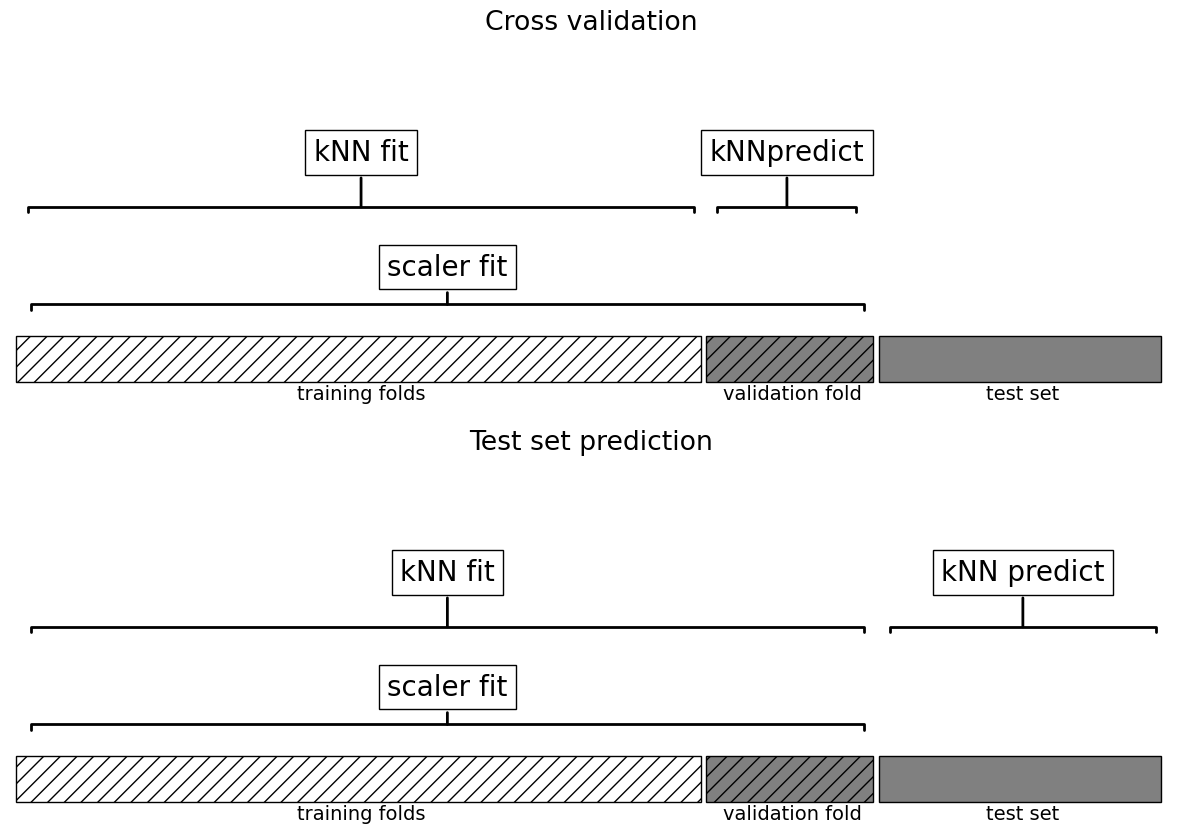

In [33]:
plot_improper_processing("kNN")

<br><br><br><br>

#### How would you do it properly? Enter sklearn pipelines!!

In [34]:
# Create a pipeline 
pipe_knn = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    KNeighborsClassifier()
)

In [35]:
cross_val_score(pipe_knn, X_train_num, y_train).mean()

np.float64(0.47810154525386317)

- What is happening under the hood? 
- Why is this a better approach? 

<img src='../../img/pipeline.png' width="800">
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

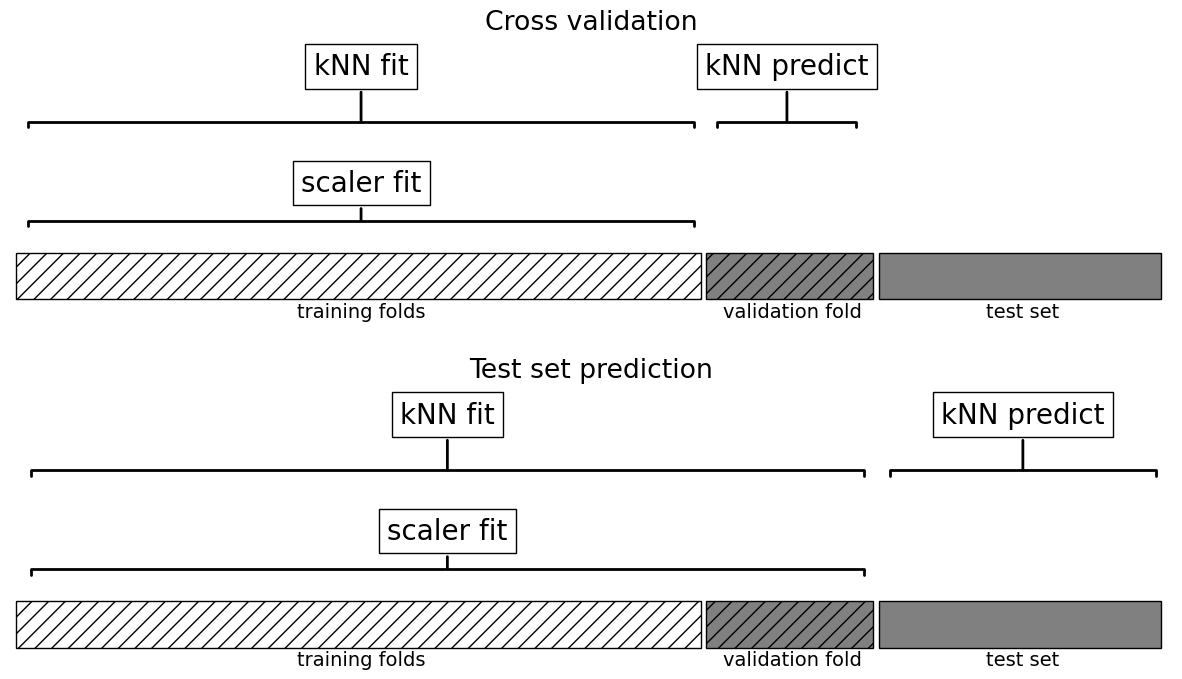

In [36]:
plot_proper_processing("kNN")

<br><br><br><br>

### Categorical features

Let's assess the scores using categorical features.

In [37]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

In [38]:
X_train[categorical_feats]

,food_type
80,Chinese
934,Canadian/American
911,Canadian/American
459,Quebecois
62,Indian
...,...
106,Chinese
333,Other
393,Canadian/American
376,NaN


In [39]:
X_train['north_america'].value_counts()

north_america
Yes                    415
No                     330
Don't want to share      8
Name: count, dtype: int64

In [40]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

In [41]:
X_train_cat = X_train[categorical_feats]
X_test_cat = X_test[categorical_feats]

In [44]:
# One-hot encoding of categorical features 
from sklearn.preprocessing import OneHotEncoder
# Create class object
ohe = OneHotEncoder(sparse_output=False)

# fit OneHotEncoder
ohe.fit(X_train_cat)

# Transform
X_train_cat_ohe  = ohe.transform(X_train_cat)
X_test_cat_ohe  =  ohe.transform(X_test_cat)

In [45]:
X_train_cat_ohe

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], shape=(753, 10))

- It's a sparse matrix. 
- Why? What would happen if we pass `sparse_output=False`? Why we might want to do that? 

In [46]:
# Get the OHE feature names 
ohe_feats = ohe.get_feature_names_out().tolist()
ohe_feats

['food_type_Canadian/American',
 'food_type_Chinese',
 'food_type_Fusion',
 'food_type_Indian',
 'food_type_Italian',
 'food_type_Mexican',
 'food_type_Other',
 'food_type_Quebecois',
 'food_type_Thai',
 'food_type_nan']

In [47]:
pd.DataFrame(X_train_cat_ohe, columns = ohe_feats)

,food_type_Canadian/American,food_type_Chinese,food_type_Fusion,food_type_Indian,food_type_Italian,food_type_Mexican,food_type_Other,food_type_Quebecois,food_type_Thai,food_type_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
750,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
cross_val_score(knn, X_train_cat_ohe, y_train).mean()

np.float64(0.575046357615894)

- What's wrong here? 
- How can we fix this?

<br><br><br><br><br><br>

Let's do this properly with a pipeline. 

In [52]:
# Code to create a pipeline for OHE and KNN
pipe_ohe_knn = make_pipeline(
    OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
    KNeighborsClassifier()
)

In [54]:
cross_val_score(pipe_ohe_knn, X_train_cat, y_train).mean()

np.float64(0.575046357615894)

### Ordinal features

Let's examine the scores using ordinal features.

In [55]:
X_train['noise_level'].value_counts()

noise_level
medium        232
low           186
high           75
no music       37
crazy loud     18
Name: count, dtype: int64

In [60]:
X_train['noise_level'].isnull().sum()

np.int64(205)

In [56]:
noise_cats

['no music', 'low', 'medium', 'high', 'crazy loud']

In [65]:
pipe_ordinal_knn = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[noise_cats]),
    KNeighborsClassifier()
)

In [67]:
cross_val_score(pipe_ordinal_knn, X_train[['noise_level']], y_train).mean()

np.float64(0.5471258278145695)

<br><br><br><br><br><br>

In [ ]:
X_train['noise_level'].isnull().any()

There are missing values. So we need an imputer. 

In [68]:
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[noise_cats]),
    KNeighborsClassifier()
)

In [69]:
cross_val_score(ordinal_transformer, X_train[['noise_level']], y_train)

array([0.54966887, 0.52980132, 0.57615894, 0.50666667, 0.57333333])

<br><br><br><br>

Right now we are working with numeric and categorical features separately. But ideally when we create a model, we need to use all these features together. 

**Enter column transformer!**

How can we horizontally stack  
- preprocessed numeric features, 
- preprocessed binary features, 
- preprocessed ordinal features, and 
- preprocessed categorical features?

Let's define a column transformer. 

In [89]:
from sklearn.compose import make_column_transformer

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OneHotEncoder(drop="if_binary")
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[noise_cats])
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_feats),
    (binary_transformer, binary_feats),
    (ordinal_transformer, ordinal_feats),
    (categorical_transformer, categorical_feats),
    ("drop", drop_feats)
)

How does the transformed data look like? 

In [90]:
drop_feats

['comments', 'north_america', 'restaurant_name']

In [91]:
categorical_feats

['food_type']

In [92]:
X_train.shape

(753, 10)

In [93]:
transformed = preprocessor.fit_transform(X_train)

In [94]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'eat_out_freq', 'n_people', 'price']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['good_server'])...
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['no '
                                                                              'music',
                                                                              'low',
                                                                              'medium',
                                                                              'high',
                                                                              'crazy '
                                                                              'loud']]))]),
                                 ['noise_level']),
                                ('pipeline-4',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['food_type']),
                                ('drop', 'drop',
                                 ['comments', 'north_america',
                                  'restaurant_name'])])

In [95]:
# Getting feature names from a column transformer

In [96]:
ohe_feat_names = preprocessor.named_transformers_["pipeline-4"]["onehotencoder"].get_feature_names_out(categorical_feats).tolist()
ohe_feat_names

['food_type_Canadian/American',
 'food_type_Chinese',
 'food_type_Fusion',
 'food_type_Indian',
 'food_type_Italian',
 'food_type_Mexican',
 'food_type_Other',
 'food_type_Quebecois',
 'food_type_Thai']

In [97]:
feat_names = numeric_feats + binary_feats + ordinal_feats + ohe_feat_names
feat_names

['age',
 'eat_out_freq',
 'n_people',
 'price',
 'good_server',
 'noise_level',
 'food_type_Canadian/American',
 'food_type_Chinese',
 'food_type_Fusion',
 'food_type_Indian',
 'food_type_Italian',
 'food_type_Mexican',
 'food_type_Other',
 'food_type_Quebecois',
 'food_type_Thai']

In [98]:
transformed

array([[-0.66941678, -0.25498295,  0.31029469, ...,  0.        ,
         0.        ,  0.        ],
       [-0.66941678,  0.6507517 ,  0.31029469, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89515383,  0.6507517 ,  0.82336432, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.89515383,  0.6507517 , -0.97237936, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89515383,  1.10361902, -0.20277493, ...,  1.        ,
         0.        ,  0.        ],
       [-0.89515383,  0.6507517 ,  1.33643394, ...,  0.        ,
         0.        ,  0.        ]], shape=(753, 15))

In [99]:
pd.DataFrame(transformed, columns = feat_names)

,age,eat_out_freq,n_people,price,good_server,noise_level,food_type_Canadian/American,food_type_Chinese,food_type_Fusion,food_type_Indian,food_type_Italian,food_type_Mexican,food_type_Other,food_type_Quebecois,food_type_Thai
0,-0.669417,-0.254983,0.310295,-0.368406,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.669417,0.650752,0.310295,-0.054225,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.895154,0.650752,0.823364,-0.250588,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.669417,1.103619,-0.202775,-0.250588,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.007794,-0.254983,-0.202775,-0.054225,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.685006,0.197884,-0.715845,-0.643315,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749,0.007794,-0.707850,-0.613231,-0.918224,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
750,-0.895154,0.650752,-0.972379,-0.643315,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,-0.895154,1.103619,-0.202775,-0.250588,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


We have new columns for the categorical features. Let's create a pipeline with the preprocessor and SVC. 

In [104]:
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    preprocessor,
    SVC()
)

cross_val_score(pipe_svc, X_train, y_train).mean()

np.float64(0.6759470198675496)

We are getting better results! 
<br><br><br>

### Incorporating text features 

We haven't incorporated the comments feature into our pipeline yet, even though it holds significant value in indicating whether the restaurant was liked or not.

In [105]:
X_train

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name
80,No,2.0,21,30.0,2200.0,Chinese,high,No,The environment was very not clean. The food tasted awful.,NaN
934,Yes,4.0,21,30.0,3000.0,Canadian/American,low,Yes,The building and the room gave a very comfy feeling. Immediately after sitting down it felt like we were right at home.,NaN
911,No,4.0,20,40.0,2500.0,Canadian/American,medium,Yes,I was hungry,Chambar
459,Yes,5.0,21,NaN,NaN,Quebecois,NaN,NaN,NaN,NaN
62,Yes,2.0,24,20.0,3000.0,Indian,high,Yes,bad taste,east is east
...,...,...,...,...,...,...,...,...,...,...
106,No,3.0,27,10.0,1500.0,Chinese,medium,Yes,Food wasn't great.,NaN
333,No,1.0,24,12.0,800.0,Other,medium,Yes,NaN,NaN
393,Yes,4.0,20,5.0,1500.0,Canadian/American,low,No,NaN,NaN
376,Yes,5.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's create bag-of-words representation of the `comments` feature. But first we need to impute the rows where there are no comments. There is a small complication if we want to put `SimpleImputer` and `CountVectorizer` in a pipeline. 
- `SimpleImputer` takes a 2D array as input and produced 2D array as output. 
- `CountVectorizer` takes a 1D array as input. 

To deal with this, we will use sklearn's `FunctionTransformer` to convert the 2D output of `SimpleImputer` into a 1D array which can be passed to `CountVectorizer` as input. 

In [112]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

reshape_transformer = FunctionTransformer(lambda X: X.squeeze(), validate=False)

text_transform = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    reshape_transformer,
    CountVectorizer(max_features=100, stop_words="english"),
)

text_pipe = make_pipeline(
    text_transform,
    SVC()
)

cross_val_score(text_pipe, X_train[["comments"]], y_train).mean()

np.float64(0.6453951434878586)

Pretty good scores just with text features! Do we get better scores if we combine all features? Let's define a column transformer which carries out 
- imputation and scaling on numeric features
- imputation and one-hot encoding with `drop="if_binary"` on binary features
- imputation and one-hot encoding with `handle_unknown="ignore"` on categorical features
- imputation, reshaping, and bag-of-words transformation on the text feature

In [114]:
drop_feats

drop_feats_new = drop_feats[1:]
drop_feats_new

['north_america', 'restaurant_name']

In [115]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_feats),
    (binary_transformer, binary_feats),
    (ordinal_transformer, ordinal_feats),
    (categorical_transformer, categorical_feats),
    (text_transform, ["comments"]),
    ("drop", drop_feats_new)
)

full_pipe = make_pipeline(
    preprocessor,
    SVC()
)

cross_val_score(full_pipe, X_train, y_train).mean()

np.float64(0.6932538631346579)

Some improvement when we combine all features! 